# CBP Data Processing

## Summary
Notebook to extract the contents of CBP pdf on apprehensions by nationality at specfiic border crossings. 

Mostly automated but some manual work.

Additional notes:
* Totals may not match 100% - appears from comparing TOTAL column and summed totals to be off - generally low rate but would want to add more verification and testing if we plan on using or sharing this data more broadly. 
* There are many other pdfs which could be extracted - holding for now until we determine if there is value in extracting them 

dataset source: https://www.cbp.gov/newsroom/media-resources/stats <br>
specific file link: https://www.cbp.gov/sites/default/files/assets/documents/2021-Aug/USBORD~3.PDF

In [1]:
print("My notebook is running !!")

My notebook is running !!


In [8]:
from google.colab import drive

drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


**Change the directory to your local copy of the data repo**

In [9]:
%cd /content/drive/MyDrive/data-repo-mvps

/content/drive/Shareddrives/Data Products Team/Products/Immigration Data Hub/DataRepo/data-repo-mvp


In [1]:
%pip install PyPDF2
%pip install tabula-py

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [90]:
import pandas as pd
import requests
import tabula
from tabula.io import read_pdf

from pathlib import Path
from PyPDF2 import PdfFileReader

pd.set_option("max_rows", 400)

In [6]:
def download_pdf(url, name, output_folder):
    """
    Function to download a single pdf file from a provided link.

    Parameters:
      url: Url of the file you want to download
      name: name label you want to apply to the file
      output_folder: Folder path to savae file

    Returns:
      Saves the file to the output directory, function itself returns nothing.

    Example:
      download_pdf(
        'https://travel.state.gov/content/travel/en/legal/visa-law0/visa-statistics/immigrant-visa-statistics/monthly-immigrant-visa-issuances.html',
        'July 2020 - IV Issuances by Post and Visa Class',
        'visa_test/'
      )
    """
    output_folder = Path(output_folder)
    response = requests.get(url)
    if response.status_code == 200:
        # Write content in pdf file
        outpath = output_folder / f"{name}.pdf"
        pdf = open(str(outpath), "wb")
        pdf.write(response.content)
        pdf.close()
        print("File ", f"{name}.pdf", " downloaded")
    else:
        print("File ", f"{name}.pdf", " not found.")

**Below we pass the:**
* Path to the pdf file on the internet
* What we want to call it 
* And the folder we want to save the file to

In [9]:
download_pdf(
    "https://www.cbp.gov/sites/default/files/assets/documents/2021-Aug/USBORD~3.PDF",  # <- the url
    "US Border Patrol Nationwide Apps by Citizenship & Sector",  # <- our name for it
    "../data/raw_source_files/",  # <- Output directory
)

File  US Border Patrol Nationwide Apps by Citizenship & Sector.pdf  downloaded


**We have now downloaded the file locally**

This file is somewhat hard to extract data from. The columns merged fields and sub headings etc. Also if you scroll through the whole file you will see that the table format changes somewhat. Therefore we are going to hardcode the actual columnns we are interested in. Below we see an image of the first table in the pdf. 

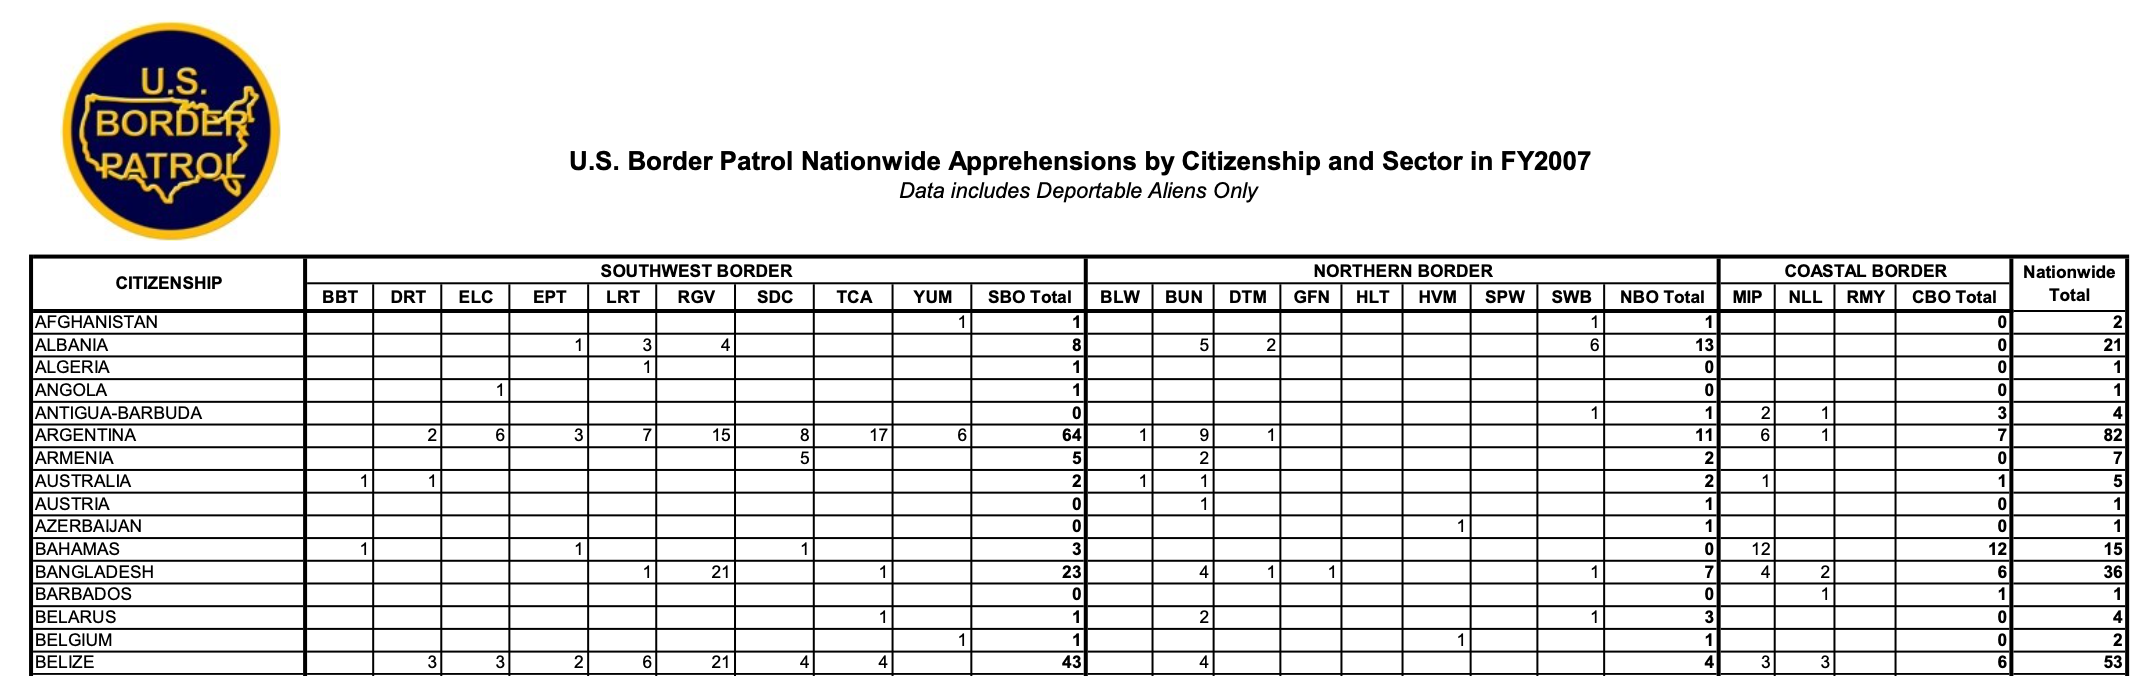

And.. below we create a variable called `cols` where we save the columns names we will use in our table. These columns refer to citizenship of the person, where they were encountered and different aggregations based on border location (SW, North, Coast). 

In [16]:
cols = [
    "citizenship",
    "bbt",
    "drt",
    "elc",
    "ept",
    "lrt",
    "rgv",
    "sdc",
    "tca",
    "yum",
    "sbo_total",  # SBO
    "blw",
    "bun",
    "dtm",
    "gfn",
    "hlt",
    "hvm",
    "spw",
    "swb",
    "nbo_total",
    "mip",
    "nll",
    "rmy",
    "cbo_total",
    "total",
]

**Create Variable to store path to local PDF file**

In [17]:
pdf_path = "../data/raw_source_files/US Border Patrol Nationwide Apps by Citizenship & Sector.pdf"

**Now run the process**

In [92]:
print("*Starting Process")


def fix_header_pages(df):
    df.columns = cols
    df = df.drop([0, 1], axis=0)
    return df


# List to store the tables we encounter
tables = []
# Dataframe to store table segments
table_segments = pd.DataFrame()

# Start on page 1 (PDF is not zero indexed like python but regular indexed .. starts with 1 not 0)
start = 1
# Read the pdf with PdfFileReader to get the number of pages
stop = PdfFileReader(pdf_path).getNumPages() + 1

# Something to count the number of table swe encounter
table_num = -1
for page_num in range(start, stop):
    print(f" **Processing Page: {page_num} of {stop}")
    new_table = False  # New tables are where a new year starts (2007, 2008, etc)

    # Extract data using tabula
    df = read_pdf(
        pdf_path, pages=f"{page_num}", lattice=True, pandas_options={"header": None}
    )[0]

    # If it is AFGHANISTAN we have a new table
    if "AFGHANISTAN" in df.loc[2][0]:
        new_table = True
        table_num += 1

    # If CITIZENSHIP is in the first row - its a header not data so we want to remove
    if "CITIZENSHIP" in df.loc[0][0]:
        df = fix_header_pages(df)  # Mixed formats in this pdf
    else:
        df.columns = cols

    # Check for errors
    check_for_error = df[df.citizenship.str.isdigit()]
    if len(check_for_error) > 0:
        # If there was an error we try to fix it with some special tabula arguments
        fixed = False
        missing_country_df = read_pdf(
            pdf_path,
            pages=f"{page_num}",
            stream=True,
            area=(500, 5.65, 570, 5.65 + 800),
            pandas_options={"header": None},
        )[0]
        missing_country = missing_country_df.tail(1)[0].squeeze()
        print(
            f"  *** --> ERROR!! pg:{page_num}, country={missing_country}, review table_num={table_num} in tables (list object) - if not fixed automatically"
        )

        if missing_country_df.shape[1] == df.shape[1]:
            fixed = True
            print("  *** --> --> !! Success - Likely Fixed Automatically")
            missing_country_df.columns = cols
            df.loc[check_for_error.index[0]] = missing_country_df.iloc[-1]
        if not fixed:
            df.loc[
                check_for_error.index[0], "citizenship"
            ] = f"  *** -->ERROR - {missing_country}"

    # Check if new table
    if i != start and new_table:
        tables.append(table_segments)
        table_segments = df

    else:
        table_segments = table_segments.append(df)
tables.append(table_segments)
tables = [table.reset_index(drop=True) for table in tables if len(table) > 0]

print("*Process Complete")

*Starting Process
 **Processing Page: 1 of 43
 **Processing Page: 2 of 43
 **Processing Page: 3 of 43
 **Processing Page: 4 of 43
 **Processing Page: 5 of 43
 **Processing Page: 6 of 43
 **Processing Page: 7 of 43
 **Processing Page: 8 of 43
 **Processing Page: 9 of 43
 **Processing Page: 10 of 43
 **Processing Page: 11 of 43
 **Processing Page: 12 of 43
 **Processing Page: 13 of 43
 **Processing Page: 14 of 43
 **Processing Page: 15 of 43
 **Processing Page: 16 of 43
 **Processing Page: 17 of 43
 **Processing Page: 18 of 43
 **Processing Page: 19 of 43
 **Processing Page: 20 of 43
 **Processing Page: 21 of 43
 **Processing Page: 22 of 43
 **Processing Page: 23 of 43
 **Processing Page: 24 of 43
 **Processing Page: 25 of 43
 **Processing Page: 26 of 43
 **Processing Page: 27 of 43
 **Processing Page: 28 of 43
 **Processing Page: 29 of 43
 **Processing Page: 30 of 43
 **Processing Page: 31 of 43
 **Processing Page: 32 of 43
 **Processing Page: 33 of 43
 **Processing Page: 34 of 43
 **Pr

## Manual Fixes
Above, we see that there were 3 errors. 

1. pg: 35, Syria
2. pg: 37, Ireland
3. pg: 38, Unknown

We were able to fix `#2` automatically but `#1` and `#3` need manual correction. 

If you are wondering why these were not collected correctly it is because on pg 35, 37 and 38 the table is missing a strong black line at the bottom of the table. 

Tabula uses strong lines to differentiate data from other parts of the pdf. Below we see the pg 35, Syria example. 

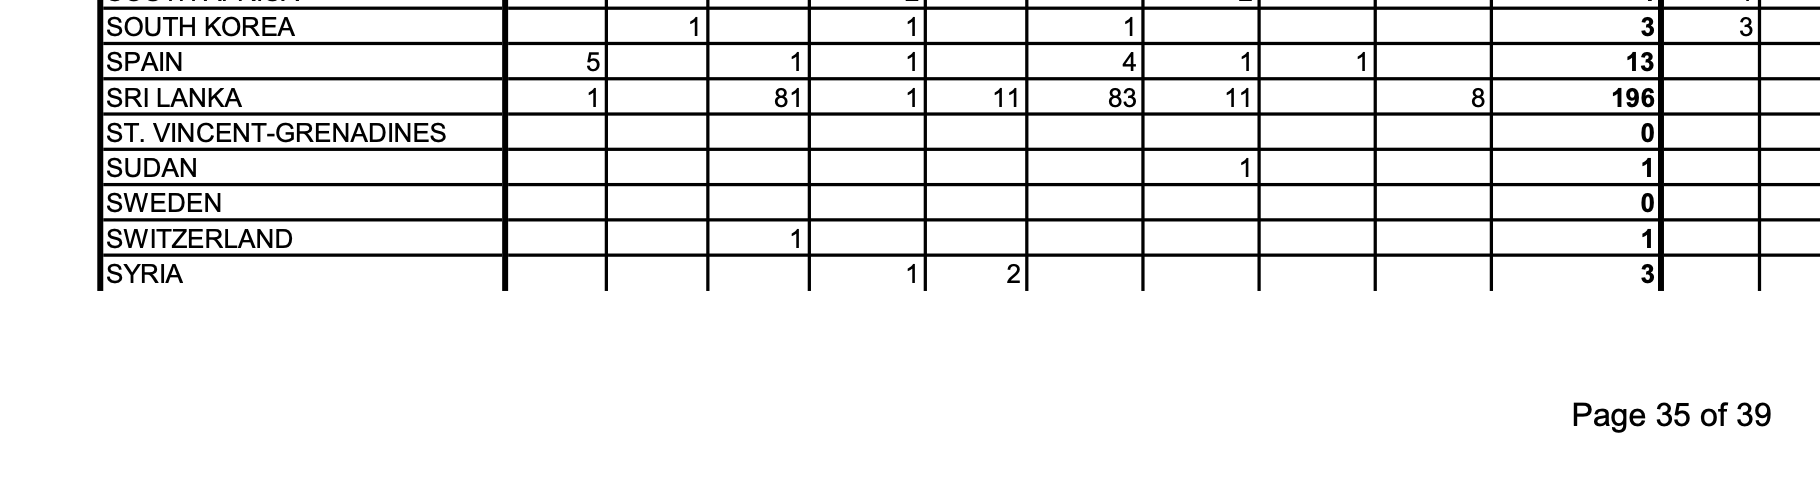

We can examine the actual data by reviweing the table in the `tables` list. 

In [53]:
example = tables[12].reset_index()
example.iloc[117:120]

,index,citizenship,bbt,drt,elc,ept,lrt,rgv,sdc,tca,...,hlt,hvm,spw,swb,nbo_total,mip,nll,rmy,cbo_total,total
117,117,SWITZERLAND,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,1
118,118,*** -->ERROR - SYRIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,119,TAIWAN,NaN,NaN,NaN,2,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,0,5


Above we look at table `#12` which referes to FY2018, and specifically the end of page 35 and the beginning of page 36. We see that SYRIA has no information. But if we look at the pdf (see image above) it does have information. 

Therefore we will have to correct this manually.


**Below is just a list of values that provides the information that was not collected for Syria on pg 35**

In [54]:
syria_correct = [
    "SYRIA",
    0,
    0,
    0,
    1,
    2,
    0,
    0,
    0,
    0,
    3,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    3,
]
len(syria_correct)

25

**And then the Unkown countries for page 38**

In [55]:
unknown_correct = [
    "UNNKOWN",
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
]
len(unknown_correct)

25

**We grab the table and then assign the correct data to that row**

Fix Syria

In [56]:
# the value assigned to tbl_index corresponds to the table_num value shown in our error message for each country
tbl_index = 11
tables[tbl_index].loc[
    tables[tbl_index][tables[tbl_index].citizenship.str.contains("SYRIA")].index[0]
] = syria_correct

Fix Unkown

In [57]:
tbl_index = 12
tables[tbl_index].loc[
    tables[tbl_index][tables[tbl_index].citizenship.str.contains("UNKNOWN")].index[0]
] = unknown_correct

## Clean Up Tables

We need to remove commas from numbers and convert string numbers to actual integer values. We will also create a dictionary with the cleaned tables and better labels

In [70]:
# Get just the specific station/crossing columns (not totals)
station_cols = [
    i
    for i in cols
    if i not in ["citizenship", "sbo_total", "nbo_total", "cbo_total", "total"]
]

total_cols = ["sbo_total", "nbo_total", "cbo_total", "total"]


def clean_tables(df):
    df = df.fillna(0).reset_index(drop=True)
    df["total"] = [
        int(i.replace(",", "")) if isinstance(i, str) else i for i in df["total"]
    ]
    for c in station_cols + total_cols:
        df.loc[:, c] = [
            int(i.replace(",", "")) if isinstance(i, str) else i for i in df[c]
        ]

    return df

In [71]:
data = {
    f"total_apprehensions_FY{idx+7:02}": clean_tables(df)
    for idx, df in enumerate(tables)
}

**Here are the keys in the dictionary - they relate to the specific `FY-Year` of the data**

In [73]:
data.keys()

dict_keys(['total_apprehensions_FY07', 'total_apprehensions_FY08', 'total_apprehensions_FY09', 'total_apprehensions_FY10', 'total_apprehensions_FY11', 'total_apprehensions_FY12', 'total_apprehensions_FY13', 'total_apprehensions_FY14', 'total_apprehensions_FY15', 'total_apprehensions_FY16', 'total_apprehensions_FY17', 'total_apprehensions_FY18', 'total_apprehensions_FY19', 'total_apprehensions_FY20'])

**Sanity Check**

We can compare the `TOTAL` column to the actual summed row totals to see if the data was extracted correctly

In [76]:
table_name = "total_apprehensions_FY19"
totals = data[table_name].query('citizenship == "TOTAL"')
pd.concat(
    [data[table_name].query('citizenship != "TOTAL"').sum(axis=0), totals.T], axis=1
)

,0,148
citizenship,AFGHANISTANALBANIAALGERIAANGOLAANTIGUA-BARBUDA...,TOTAL
bbt,9637,9637
drt,57268,57269
elc,35139,35138
ept,182143,182143
lrt,38378,38378
rgv,339135,339135
sdc,58049,58049
tca,63490,63490
yum,68269,68269


Looks pretty good! 

## Combine the data into a single dataframe

We will create a single dataframe but will add two columns, one (`label`) that will store the file key, and two (`year`) the fiscal year. 

In [80]:
combined = pd.DataFrame()
for k in data:
    tmp = data[k]
    tmp["label"] = k
    combined = combined.append(tmp)

In [81]:
combined["year"] = combined.label.apply(lambda x: int(f"20{x[-2:]}"))

In [82]:
combined

,citizenship,bbt,drt,elc,ept,lrt,rgv,sdc,tca,yum,...,spw,swb,nbo_total,mip,nll,rmy,cbo_total,total,label,year
0,AFGHANISTAN,0,0,0,0,0,0,0,0,1,...,0.0,1.0,1,0,0.0,0.0,0,2,total_apprehensions_FY07,2007
1,ALBANIA,0,0,0,1,3,4,0,0,0,...,0.0,6.0,13,0,0.0,0.0,0,21,total_apprehensions_FY07,2007
2,ALGERIA,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0,1,total_apprehensions_FY07,2007
3,ANGOLA,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0,1,total_apprehensions_FY07,2007
4,ANTIGUA-BARBUDA,0,0,0,0,0,0,0,0,0,...,0.0,1.0,1,2,1.0,0.0,3,4,total_apprehensions_FY07,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,YEMEN,0,8,1,2,1,4,5,0,7,...,0.0,0.0,0,0,0.0,0.0,0,28,total_apprehensions_FY20,2020
138,YUGOSLAVIA,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1,0,0.0,0.0,0,1,total_apprehensions_FY20,2020
139,ZAMBIA,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1,1,0.0,0.0,1,2,total_apprehensions_FY20,2020
140,ZIMBABWE,0,0,0,0,0,1,0,0,0,...,0.0,0.0,1,0,0.0,0.0,0,2,total_apprehensions_FY20,2020


In [83]:
combined.citizenship = [str(i) for i in combined.citizenship]

**Save file to csv**

In [85]:
combined.to_csv("../data/extracted_data/cbp-apprehensions-nov2021.csv")

# Examine

An example plot of this data 

<AxesSubplot:title={'center':'FY07-19 Total Apprehensions by Citizenship at US Borders'}, xlabel='year'>

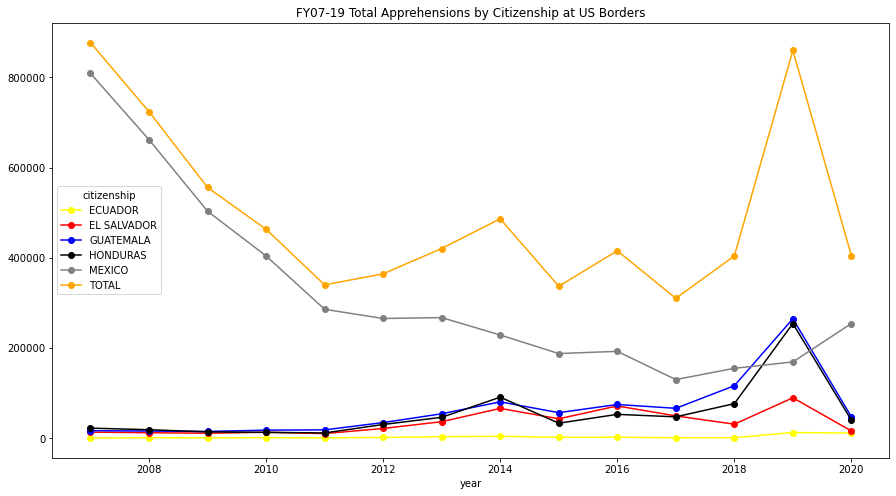

In [88]:
pd.pivot(
    index="year",
    columns="citizenship",
    values="total",
    data=combined[
        combined.citizenship.isin(
            combined.groupby("citizenship")
            .sum()
            .sort_values("total", ascending=False)
            .head(6)
            .index.tolist()
        )
    ],
).plot(
    figsize=(15, 8),
    marker="o",
    color=["yellow", "red", "blue", "black", "gray", "orange"],
    title="FY07-19 Total Apprehensions by Citizenship at US Borders",
)

# End